In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


* **Getting the train and test dataset**

In [4]:
BATCH_SIZE = 4

# Define the Transform class
class Transform():
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define the SeismicDataset class
class SeismicDataset(Dataset):
    def __init__(self, elastic_patches, acoustic_patches):
        self.elastic_patches = elastic_patches
        self.acoustic_patches = acoustic_patches
        self.trasformer = Transform()

    def __len__(self):
        return len(self.elastic_patches)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        elastic_patch = self.elastic_patches[idx]
        acoustic_patch = self.acoustic_patches[idx]
        elastic_patch  = self.trasformer(elastic_patch)
        acoustic_patch = self.trasformer(acoustic_patch)
        return elastic_patch, acoustic_patch

# Function to load binary data
def load_bin_data(file, samples):
    data = np.fromfile(file, dtype='float32')
    nrecs = data.size // samples
    data = data.reshape(nrecs, samples).T
    return data

def preprocess_patches(patches):
    # Normalize and add channel dimension for grayscale images
    max = abs(np.max(patches))
    min = abs(np.min(patches))
    maxi = np.max([max, min])
    patches = patches/maxi  # Normalize to [-1, 1]
    return patches[..., np.newaxis]  # Add channel dimension

# Function to split data into patches
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    patches = []
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return np.array(patches)

# Function to remove all-zero patches and maintain pairing
def remove_zero_and_same_value_patches(elastic_patches, acoustic_patches):
    paired_patches = []
    for e_patch, a_patch in zip(elastic_patches, acoustic_patches):
        if not np.all(e_patch <= 1e-4) and not np.all(a_patch <= 1e-4) and \
           len(np.unique(e_patch)) > 1 and len(np.unique(a_patch)) > 1:
            paired_patches.append((e_patch, a_patch))
    
    # Unzip the list of tuples back into separate arrays
    elastic_patches, acoustic_patches = zip(*paired_patches)
    return np.array(elastic_patches), np.array(acoustic_patches)

# Function to process folder
def process_folder(data_dir_elastic, data_dir_acoustic, idx_train, samples=768, patch_size=256):
    all_data_train_elastic = []
    all_data_test_elastic = []
    all_data_train_acoustic = []
    all_data_test_acoustic = []

    # Combine elasticdata and acousticdata based on idx_train
    for idx in range(1,362):
        elastic_file = f"Elasticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_train_elastic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_test_elastic.append(data)

    for idx in range(1,362):
        acoustic_file = f"Acusticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_train_acoustic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_test_acoustic.append(data)

    print(f'Train seismograms length : {len(all_data_train_elastic)}')
    print(f'Train seismograms length : {len(all_data_train_acoustic)}')

    return np.array(all_data_train_elastic), np.array(all_data_test_elastic), np.array(all_data_train_acoustic), np.array(all_data_test_acoustic)

# Paths to the directories
elastic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data\Elastic_data\Vxfield'
acoustic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data\Acustic_data\Pfield'

# 80% of the files are used for training
n_train = 300
idx_train = np.sort(random.sample(range(1, 361), n_train))

# Load and separate data
train_elastic, test_elastic, train_acoustic, test_acoustic = process_folder(elastic_dir, acoustic_dir, idx_train)

# Split training data into patches
vertical_overlap = 128 # five vertical windowns
horizontal_overlap = 151 # two horizontal windowns
patch_size = 256
train_elastic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_elastic])
train_acoustic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_acoustic])

# Preprocess and create datasets
test_elastic_patches = preprocess_patches(test_elastic)
test_acoustic_patches = preprocess_patches(test_acoustic)
train_elastic_patches = preprocess_patches(train_elastic_patches)
train_acoustic_patches = preprocess_patches(train_acoustic_patches)

# # Remove zero patches and maintain pairing
# train_elastic_patches, train_acoustic_patches = remove_zero_and_same_value_patches(train_elastic_patches, train_acoustic_patches)
# test_elastic_patches, test_acoustic_patches = remove_zero_and_same_value_patches(test_elastic_patches, test_acoustic_patches)

# Create the dataset with paired data
test_ds = SeismicDataset(test_acoustic_patches, test_elastic_patches)
train_ds = SeismicDataset(train_acoustic_patches, train_elastic_patches)

# Create the DataLoader with the desired parameters
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Train seismograms length : 300
Train seismograms length : 300


In [5]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 15


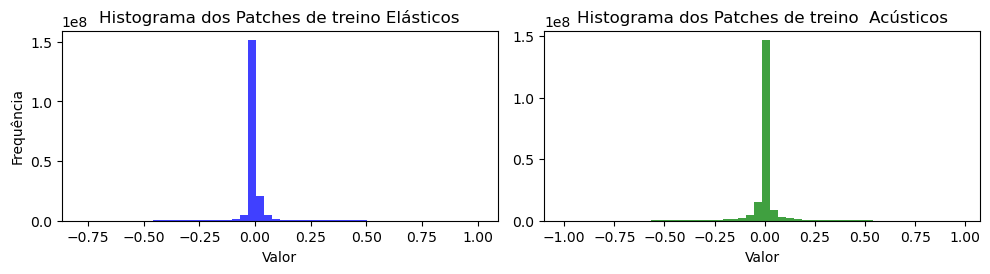

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

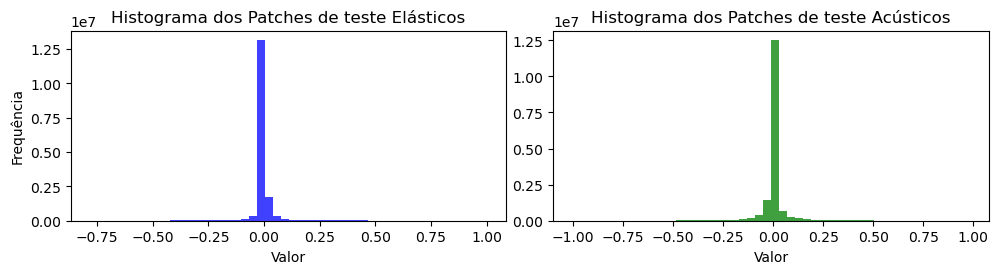

In [7]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

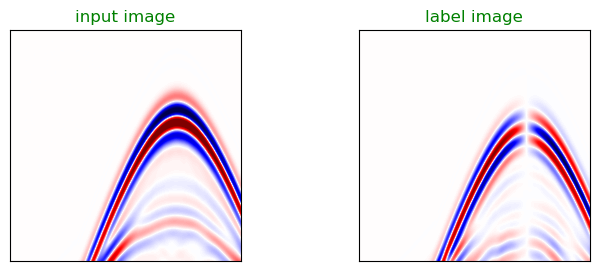

In [8]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("label image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

* **Define the generator and discriminator**

In [10]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, 4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, 4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

* **Define the Loss**

In [13]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() # Perda quadrática

* **Inicializando os modelos na GPU**

In [15]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [16]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [17]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input')
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target')
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image')
        ax[2].axis('off')

       # # Desconecta os tensores e converte para numpy antes de exibir
       #  real_output_img = real_output[0, 0].detach().cpu().numpy()
       #  fake_output_img = fake_output[0, 0].detach().cpu().numpy()

       #  # Mostra o resultado do discriminador para a imagem real
       #  im1 = ax[1, 0].imshow(real_output_img, cmap='RdBu_r')
       #  ax[1, 0].set_title('Discriminator Output (Real Target)')
       #  ax[1, 0].axis('off')

       #  # Mostra o resultado do discriminador para a imagem gerada
       #  im2 = ax[1, 1].imshow(fake_output_img, cmap='RdBu_r')
       #  ax[1, 1].set_title('Discriminator Output (Generated Image)')
       #  ax[1, 1].axis('off')

        # fig.colorbar(im1, ax=ax[0])
        # fig.colorbar(im2, ax=ax[1])
        # fig.colorbar(im3, ax=ax[2])

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


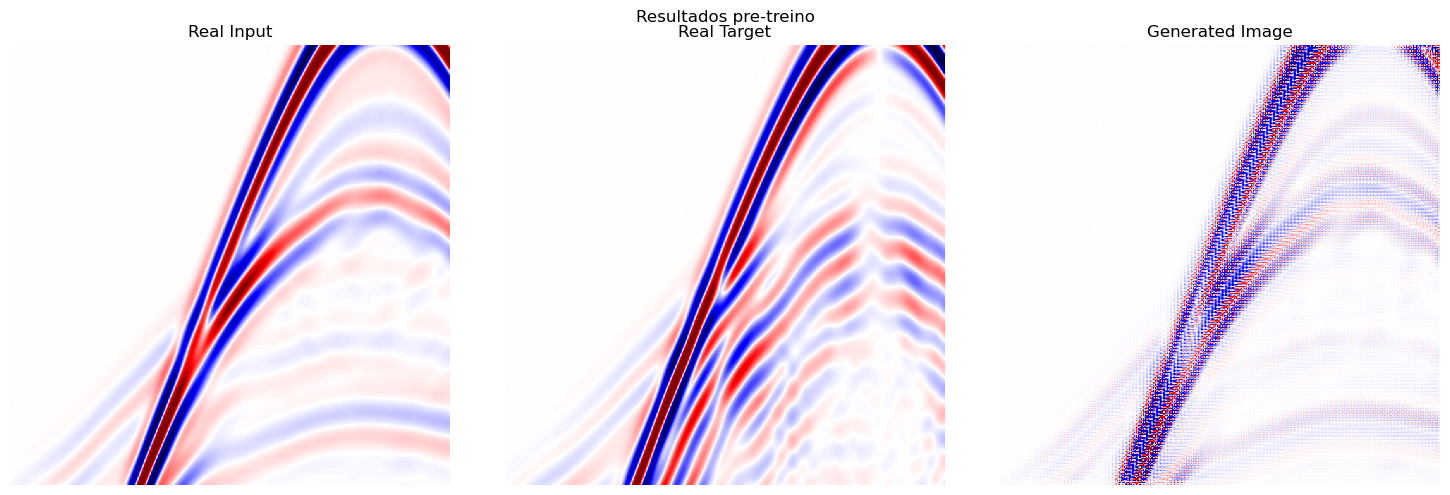

In [18]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [19]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [20]:
n_epoches = 200
decay_epoch = 100 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 10000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) 
        # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com base na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator """
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D(input, target), real_label)
        loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
        loss_D = (loss_real + loss_fake) * 0.5
        
        loss_D.backward()
        optimizer_D.step()
        
    lr_scheduler_G.step()
    lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 1/200]
[G loss: 142.45130920410156 | GAN: 4.551635265350342 L1: 0.013789966702461243]
[D loss: 0.026971321552991867]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.05it/s]


[Epoch 2/200]
[G loss: 129.35696411132812 | GAN: 5.645151138305664 L1: 0.012371181510388851]
[D loss: 0.006150422617793083]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 3/200]
[G loss: 90.06513214111328 | GAN: 4.831804275512695 L1: 0.008523332886397839]
[D loss: 0.009816769510507584]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 4/200]
[G loss: 152.6529541015625 | GAN: 0.8817886710166931 L1: 0.015177116729319096]
[D loss: 0.46981245279312134]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 5/200]
[G loss: 62.676361083984375 | GAN: 4.9281511306762695 L1: 0.005774821154773235]
[D loss: 0.02457408979535103]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.28it/s]


[Epoch 6/200]
[G loss: 79.70894622802734 | GAN: 2.386660099029541 L1: 0.007732228841632605]
[D loss: 0.6499181985855103]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 7/200]
[G loss: 112.20120239257812 | GAN: 3.0047688484191895 L1: 0.010919643566012383]
[D loss: 0.1030854731798172]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 8/200]
[G loss: 63.1107063293457 | GAN: 2.0731940269470215 L1: 0.006103751249611378]
[D loss: 0.13833579421043396]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 9/200]
[G loss: 21.390100479125977 | GAN: 1.578621745109558 L1: 0.0019811480306088924]
[D loss: 0.2915583550930023]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 10/200]
[G loss: 28.96080207824707 | GAN: 1.8577817678451538 L1: 0.0027103018946945667]
[D loss: 0.20142778754234314]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 11/200]
[G loss: 13.653763771057129 | GAN: 4.040445327758789 L1: 0.0009613318834453821]
[D loss: 0.0521785169839859]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 12/200]
[G loss: 44.44928741455078 | GAN: 4.589323997497559 L1: 0.0039859963580966]
[D loss: 0.016321346163749695]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 13/200]
[G loss: 56.58816909790039 | GAN: 6.94879674911499 L1: 0.0049639372155070305]
[D loss: 0.004289488308131695]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 14/200]
[G loss: 51.88265609741211 | GAN: 5.9675493240356445 L1: 0.004591510631144047]
[D loss: 0.0044883619993925095]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 15/200]
[G loss: 28.221603393554688 | GAN: 0.2295566350221634 L1: 0.0027992045506834984]
[D loss: 1.186410665512085]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 16/200]
[G loss: 38.295616149902344 | GAN: 7.95428466796875 L1: 0.003034133231267333]
[D loss: 0.000845920410938561]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 17/200]
[G loss: 53.464019775390625 | GAN: 4.359517574310303 L1: 0.004910450428724289]
[D loss: 0.017067592591047287]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 18/200]
[G loss: 70.00421142578125 | GAN: 8.3009614944458 L1: 0.006170324981212616]
[D loss: 0.006519448943436146]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 19/200]
[G loss: 52.054466247558594 | GAN: 7.828214645385742 L1: 0.0044226255267858505]
[D loss: 0.0018326048739254475]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 20/200]
[G loss: 51.800315856933594 | GAN: 2.627162218093872 L1: 0.00491731520742178]
[D loss: 0.8182252049446106]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 21/200]
[G loss: 56.091773986816406 | GAN: 7.258493900299072 L1: 0.00488332798704505]
[D loss: 0.014644473791122437]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 22/200]
[G loss: 31.465347290039062 | GAN: 6.745336055755615 L1: 0.002472001127898693]
[D loss: 0.0016394468257203698]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 23/200]
[G loss: 18.175230026245117 | GAN: 1.2872480154037476 L1: 0.0016887980746105313]
[D loss: 0.7099272608757019]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 24/200]
[G loss: 51.05195617675781 | GAN: 9.239538192749023 L1: 0.004181241616606712]
[D loss: 0.0011577641125768423]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 25/200]
[G loss: 57.20949172973633 | GAN: 4.138041973114014 L1: 0.0053071449510753155]
[D loss: 0.21745498478412628]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 26/200]
[G loss: 52.769927978515625 | GAN: 7.62355899810791 L1: 0.004514636937528849]
[D loss: 0.0026183174923062325]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s]


[Epoch 27/200]
[G loss: 43.97043228149414 | GAN: 10.609545707702637 L1: 0.0033360887318849564]
[D loss: 0.0011077806120738387]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s]


[Epoch 28/200]
[G loss: 36.94688034057617 | GAN: 12.0584716796875 L1: 0.002488840837031603]
[D loss: 0.00018025821191258729]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.24it/s]


[Epoch 29/200]
[G loss: 52.901527404785156 | GAN: 6.321289539337158 L1: 0.004658023826777935]
[D loss: 0.005668454337865114]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 30/200]
[G loss: 22.687700271606445 | GAN: 4.840050220489502 L1: 0.001784765045158565]
[D loss: 0.010978944599628448]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 31/200]
[G loss: 63.72978973388672 | GAN: 9.865089416503906 L1: 0.0053864698857069016]
[D loss: 0.000987527659162879]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 32/200]
[G loss: 53.55233383178711 | GAN: 8.295405387878418 L1: 0.004525692667812109]
[D loss: 0.0008791302097961307]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 33/200]
[G loss: 39.86111831665039 | GAN: 8.180928230285645 L1: 0.003168019000440836]
[D loss: 0.0007533127209171653]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 34/200]
[G loss: 34.681419372558594 | GAN: 1.0213865041732788 L1: 0.0033660035114735365]
[D loss: 0.37072035670280457]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 35/200]
[G loss: 31.67134666442871 | GAN: 9.84689712524414 L1: 0.0021824450232088566]
[D loss: 0.00017009915609378368]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 36/200]
[G loss: 25.921932220458984 | GAN: 9.507803916931152 L1: 0.001641412964090705]
[D loss: 0.0004938734928146005]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 37/200]
[G loss: 33.2065315246582 | GAN: 0.6019718647003174 L1: 0.0032604560256004333]
[D loss: 0.9393883943557739]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 38/200]
[G loss: 12.697675704956055 | GAN: 4.2773847579956055 L1: 0.0008420291123911738]
[D loss: 0.016253173351287842]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 39/200]
[G loss: 34.65475082397461 | GAN: 7.037268161773682 L1: 0.0027617483865469694]
[D loss: 0.0010916106402873993]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 40/200]
[G loss: 52.101097106933594 | GAN: 9.978212356567383 L1: 0.004212288651615381]
[D loss: 0.0004210752376820892]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 41/200]
[G loss: 37.05881881713867 | GAN: 7.871955394744873 L1: 0.0029186862520873547]
[D loss: 0.0005668764933943748]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 42/200]
[G loss: 27.471256256103516 | GAN: 9.881542205810547 L1: 0.0017589714843779802]
[D loss: 0.00017257750732824206]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 43/200]
[G loss: 34.062095642089844 | GAN: 10.253129959106445 L1: 0.0023808968253433704]
[D loss: 0.00017062004189938307]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 44/200]
[G loss: 21.730621337890625 | GAN: 9.678159713745117 L1: 0.0012052461970597506]
[D loss: 0.00011184326285729185]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 45/200]
[G loss: 23.58881378173828 | GAN: 0.879543125629425 L1: 0.0022709269542247057]
[D loss: 0.5953652858734131]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 46/200]
[G loss: 52.977455139160156 | GAN: 8.376111030578613 L1: 0.004460134543478489]
[D loss: 0.0006945932982489467]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 47/200]
[G loss: 30.051862716674805 | GAN: 1.3585541248321533 L1: 0.0028693308122456074]
[D loss: 0.3590879738330841]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 48/200]
[G loss: 44.75618362426758 | GAN: 10.440360069274902 L1: 0.0034315823577344418]
[D loss: 0.00011995111708529294]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 49/200]
[G loss: 20.381372451782227 | GAN: 3.5259273052215576 L1: 0.0016855444991961122]
[D loss: 0.24936017394065857]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.47it/s]


[Epoch 50/200]
[G loss: 20.21895408630371 | GAN: 7.498532295227051 L1: 0.0012720421655103564]
[D loss: 0.0008462242549285293]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 51/200]
[G loss: 22.886905670166016 | GAN: 9.869193077087402 L1: 0.0013017712626606226]
[D loss: 0.0004485009703785181]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 52/200]
[G loss: 32.20808792114258 | GAN: 9.722198486328125 L1: 0.00224858894944191]
[D loss: 0.00017310379189439118]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 53/200]
[G loss: 41.59733581542969 | GAN: 15.364377975463867 L1: 0.002623295644298196]
[D loss: 0.00018049492791760713]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 54/200]
[G loss: 46.29430389404297 | GAN: 13.75288200378418 L1: 0.003254141891375184]
[D loss: 6.692757597193122e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 55/200]
[G loss: 24.73509407043457 | GAN: 1.9084476232528687 L1: 0.0022826646454632282]
[D loss: 0.567995548248291]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 56/200]
[G loss: 27.975587844848633 | GAN: 9.115049362182617 L1: 0.001886053942143917]
[D loss: 0.000403072452172637]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 57/200]
[G loss: 10.821399688720703 | GAN: 5.452210426330566 L1: 0.0005369189311750233]
[D loss: 0.004018688108772039]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 58/200]
[G loss: 30.11035919189453 | GAN: 10.59230899810791 L1: 0.0019518048502504826]
[D loss: 6.758295057807118e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 59/200]
[G loss: 44.99368667602539 | GAN: 8.366116523742676 L1: 0.003662757109850645]
[D loss: 0.0007157903164625168]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.32it/s]


[Epoch 60/200]
[G loss: 40.09693145751953 | GAN: 3.8361756801605225 L1: 0.0036260755732655525]
[D loss: 0.05945108085870743]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.34it/s]


[Epoch 61/200]
[G loss: 37.26834487915039 | GAN: 9.895264625549316 L1: 0.002737307921051979]
[D loss: 0.0001737843849696219]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 62/200]
[G loss: 23.83627700805664 | GAN: 6.831005096435547 L1: 0.0017005272675305605]
[D loss: 0.0010744128376245499]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 63/200]
[G loss: 7.445067882537842 | GAN: 1.584428310394287 L1: 0.0005860639503225684]
[D loss: 0.16589848697185516]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 64/200]
[G loss: 12.09822940826416 | GAN: 6.396424770355225 L1: 0.0005701804766431451]
[D loss: 0.0031721806153655052]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 65/200]
[G loss: 20.29954719543457 | GAN: 7.713811874389648 L1: 0.0012585734948515892]
[D loss: 0.0005662116454914212]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 66/200]
[G loss: 39.235748291015625 | GAN: 6.70872163772583 L1: 0.003252702532336116]
[D loss: 0.0035947670694440603]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.34it/s]


[Epoch 67/200]
[G loss: 37.19485855102539 | GAN: 9.98379135131836 L1: 0.002721106633543968]
[D loss: 0.00012257795606274158]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 68/200]
[G loss: 23.78013801574707 | GAN: 10.874160766601562 L1: 0.0012905977200716734]
[D loss: 0.00015670433640480042]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 69/200]
[G loss: 44.32855987548828 | GAN: 15.760729789733887 L1: 0.002856783103197813]
[D loss: 3.419462882447988e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 70/200]
[G loss: 23.13256072998047 | GAN: 8.483587265014648 L1: 0.0014648973010480404]
[D loss: 0.002851002151146531]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 71/200]
[G loss: 30.581645965576172 | GAN: 11.306050300598145 L1: 0.0019275593804195523]
[D loss: 0.00011201659799553454]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.42it/s]


[Epoch 72/200]
[G loss: 28.58749008178711 | GAN: 9.144960403442383 L1: 0.0019442529883235693]
[D loss: 0.0003723326954059303]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.38it/s]


[Epoch 73/200]
[G loss: 27.14820098876953 | GAN: 7.814923286437988 L1: 0.0019333276432007551]
[D loss: 0.0006012740777805448]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.47it/s]


[Epoch 74/200]
[G loss: 40.909454345703125 | GAN: 9.459112167358398 L1: 0.0031450341921299696]
[D loss: 0.0006686205742880702]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 75/200]
[G loss: 37.24853515625 | GAN: 10.789650917053223 L1: 0.0026458885986357927]
[D loss: 8.960271225078031e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 76/200]
[G loss: 19.42880630493164 | GAN: 9.894125938415527 L1: 0.0009534680284559727]
[D loss: 9.240268263965845e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 77/200]
[G loss: 35.14493942260742 | GAN: 13.006936073303223 L1: 0.002213800325989723]
[D loss: 5.355730536393821e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 78/200]
[G loss: 10.49931526184082 | GAN: 3.889676809310913 L1: 0.0006609638803638518]
[D loss: 0.016427887603640556]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 79/200]
[G loss: 29.363325119018555 | GAN: 9.82761001586914 L1: 0.001953571569174528]
[D loss: 0.00015049055218696594]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 80/200]
[G loss: 25.191659927368164 | GAN: 11.315446853637695 L1: 0.0013876212760806084]
[D loss: 5.361377407098189e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 81/200]
[G loss: 37.46690368652344 | GAN: 12.346733093261719 L1: 0.0025120172649621964]
[D loss: 7.0213369326666e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 82/200]
[G loss: 27.55103302001953 | GAN: 8.065914154052734 L1: 0.0019485119264572859]
[D loss: 0.00047284437459893525]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 83/200]
[G loss: 13.211195945739746 | GAN: 5.086312294006348 L1: 0.0008124883752316236]
[D loss: 0.007043052930384874]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 84/200]
[G loss: 11.889009475708008 | GAN: 5.32823371887207 L1: 0.0006560776382684708]
[D loss: 0.009176834486424923]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 85/200]
[G loss: 25.89645767211914 | GAN: 8.56557559967041 L1: 0.0017330882837995887]
[D loss: 0.0006428606575354934]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 86/200]
[G loss: 16.21048355102539 | GAN: 6.241335868835449 L1: 0.0009969148086383939]
[D loss: 0.0029371557757258415]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 87/200]
[G loss: 24.26944923400879 | GAN: 11.112052917480469 L1: 0.001315739587880671]
[D loss: 0.0013897096505388618]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 88/200]
[G loss: 45.753089904785156 | GAN: 14.986625671386719 L1: 0.003076646476984024]
[D loss: 0.00014105727314017713]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 89/200]
[G loss: 24.30670738220215 | GAN: 12.698796272277832 L1: 0.0011607911437749863]
[D loss: 3.89393899240531e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 90/200]
[G loss: 17.601842880249023 | GAN: 10.013009071350098 L1: 0.0007588833104819059]
[D loss: 0.0005846701678819954]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 91/200]
[G loss: 19.728572845458984 | GAN: 7.96088981628418 L1: 0.0011767682153731585]
[D loss: 0.000924707215745002]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 92/200]
[G loss: 32.27848815917969 | GAN: 9.600829124450684 L1: 0.002267765812575817]
[D loss: 0.0003425413742661476]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 93/200]
[G loss: 17.565467834472656 | GAN: 8.890443801879883 L1: 0.0008675024146214128]
[D loss: 0.00020731800759676844]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 94/200]
[G loss: 26.287418365478516 | GAN: 13.275739669799805 L1: 0.0013011679984629154]
[D loss: 2.552924706833437e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.96it/s]


[Epoch 95/200]
[G loss: 53.760498046875 | GAN: 15.772385597229004 L1: 0.0037988112308084965]
[D loss: 6.280988600337878e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.24it/s]


[Epoch 96/200]
[G loss: 41.23249816894531 | GAN: 13.72233772277832 L1: 0.002751016290858388]
[D loss: 2.882448461605236e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s]


[Epoch 97/200]
[G loss: 30.56734848022461 | GAN: 8.021002769470215 L1: 0.0022546343971043825]
[D loss: 0.0018104722257703543]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s]


[Epoch 98/200]
[G loss: 16.33505630493164 | GAN: 6.804815769195557 L1: 0.0009530239622108638]
[D loss: 0.0010994753101840615]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 99/200]
[G loss: 38.37058639526367 | GAN: 11.057056427001953 L1: 0.0027313530445098877]
[D loss: 9.778904495760798e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 100/200]
[G loss: 36.49847412109375 | GAN: 11.192863464355469 L1: 0.002530560828745365]
[D loss: 0.00020107944146730006]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 101/200]
[G loss: 34.41633224487305 | GAN: 12.273442268371582 L1: 0.0022142890375107527]
[D loss: 0.00010031904093921185]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 102/200]
[G loss: 36.19581985473633 | GAN: 12.704609870910645 L1: 0.002349121030420065]
[D loss: 9.170064004138112e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 103/200]
[G loss: 27.193552017211914 | GAN: 10.167678833007812 L1: 0.00170258735306561]
[D loss: 7.392144470941275e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 104/200]
[G loss: 34.8822021484375 | GAN: 2.600285053253174 L1: 0.003228191751986742]
[D loss: 0.09707379341125488]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 105/200]
[G loss: 19.804052352905273 | GAN: 6.8585286140441895 L1: 0.0012945523485541344]
[D loss: 0.0011012655450031161]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 106/200]
[G loss: 26.86626434326172 | GAN: 12.32040786743164 L1: 0.0014545856975018978]
[D loss: 3.27784291584976e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 107/200]
[G loss: 19.24448013305664 | GAN: 11.901335716247559 L1: 0.0007343144388869405]
[D loss: 8.85318877408281e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 108/200]
[G loss: 16.922208786010742 | GAN: 8.809755325317383 L1: 0.0008112453506328166]
[D loss: 0.0008500184630975127]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 109/200]
[G loss: 38.54879379272461 | GAN: 11.437480926513672 L1: 0.002711131237447262]
[D loss: 0.00010793298133648932]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 110/200]
[G loss: 39.65406036376953 | GAN: 14.461024284362793 L1: 0.002519303699955344]
[D loss: 6.043606481398456e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 111/200]
[G loss: 17.338083267211914 | GAN: 10.102255821228027 L1: 0.0007235826924443245]
[D loss: 0.00017661097808741033]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 112/200]
[G loss: 26.505937576293945 | GAN: 13.752235412597656 L1: 0.0012753702467307448]
[D loss: 3.0137889552861452e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 113/200]
[G loss: 39.509090423583984 | GAN: 15.410799026489258 L1: 0.0024098290596157312]
[D loss: 2.423494697723072e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 114/200]
[G loss: 23.133411407470703 | GAN: 8.538862228393555 L1: 0.001459455001167953]
[D loss: 0.0006466028280556202]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 115/200]
[G loss: 30.03034210205078 | GAN: 12.785208702087402 L1: 0.0017245134804397821]
[D loss: 2.536089414206799e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 116/200]
[G loss: 24.183048248291016 | GAN: 11.927623748779297 L1: 0.0012255425099283457]
[D loss: 3.5087789001408964e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 117/200]
[G loss: 39.567222595214844 | GAN: 12.814313888549805 L1: 0.002675290685147047]
[D loss: 0.00010298093548044562]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 118/200]
[G loss: 25.442277908325195 | GAN: 14.716588973999023 L1: 0.001072568935342133]
[D loss: 1.5950772649375722e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 119/200]
[G loss: 25.53818130493164 | GAN: 15.330597877502441 L1: 0.0010207584127783775]
[D loss: 1.4501914847642183e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 120/200]
[G loss: 41.72784423828125 | GAN: 16.522441864013672 L1: 0.0025205404963344336]
[D loss: 1.2039830835419707e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.38it/s]


[Epoch 121/200]
[G loss: 12.875325202941895 | GAN: 9.285648345947266 L1: 0.00035896769259124994]
[D loss: 0.0002808336284942925]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 122/200]
[G loss: 27.052711486816406 | GAN: 9.753762245178223 L1: 0.001729894895106554]
[D loss: 0.00019101386715192348]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 123/200]
[G loss: 39.849388122558594 | GAN: 12.128826141357422 L1: 0.0027720562648028135]
[D loss: 0.00021671387366950512]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 124/200]
[G loss: 24.01763343811035 | GAN: 7.536951065063477 L1: 0.0016480681952089071]
[D loss: 0.0008316286257468164]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 125/200]
[G loss: 38.13010787963867 | GAN: 11.020642280578613 L1: 0.0027109466027468443]
[D loss: 0.00013363774633035064]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 126/200]
[G loss: 38.46910858154297 | GAN: 13.02338981628418 L1: 0.0025445721112191677]
[D loss: 4.095550684724003e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 127/200]
[G loss: 35.40120315551758 | GAN: 14.42903995513916 L1: 0.002097216434776783]
[D loss: 2.1614119759760797e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 128/200]
[G loss: 25.7650146484375 | GAN: 14.193031311035156 L1: 0.0011571984505280852]
[D loss: 2.315084566362202e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 129/200]
[G loss: 23.96240234375 | GAN: 14.401469230651855 L1: 0.0009560933685861528]
[D loss: 3.943815318052657e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 130/200]
[G loss: 25.052335739135742 | GAN: 13.606145858764648 L1: 0.0011446189600974321]
[D loss: 4.056967736687511e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 131/200]
[G loss: 29.550703048706055 | GAN: 12.974763870239258 L1: 0.001657593878917396]
[D loss: 4.6971123083494604e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 132/200]
[G loss: 32.05692672729492 | GAN: 10.721236228942871 L1: 0.0021335692144930363]
[D loss: 6.858183041913435e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 133/200]
[G loss: 24.255123138427734 | GAN: 10.417856216430664 L1: 0.00138372671790421]
[D loss: 5.8510770031716675e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 134/200]
[G loss: 28.518978118896484 | GAN: 12.485208511352539 L1: 0.0016033770516514778]
[D loss: 1.058881389326416e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 135/200]
[G loss: 23.224132537841797 | GAN: 12.545389175415039 L1: 0.0010678742546588182]
[D loss: 1.1414285836508498e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 136/200]
[G loss: 32.803749084472656 | GAN: 16.989259719848633 L1: 0.0015814490616321564]
[D loss: 4.208635800750926e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 137/200]
[G loss: 36.652931213378906 | GAN: 14.862592697143555 L1: 0.00217903358861804]
[D loss: 1.4782641301280819e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 138/200]
[G loss: 31.293848037719727 | GAN: 18.272348403930664 L1: 0.0013021499617025256]
[D loss: 9.566482503942098e-07]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 139/200]
[G loss: 31.89466667175293 | GAN: 14.024456024169922 L1: 0.0017870210576802492]
[D loss: 8.511320629622787e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 140/200]
[G loss: 8.065326690673828 | GAN: 1.2955189943313599 L1: 0.0006769807660020888]
[D loss: 0.29000481963157654]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 141/200]
[G loss: 27.101974487304688 | GAN: 8.379890441894531 L1: 0.001872208435088396]
[D loss: 0.002605138346552849]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 142/200]
[G loss: 27.90093421936035 | GAN: 14.749199867248535 L1: 0.0013151734601706266]
[D loss: 0.00038461139774881303]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 143/200]
[G loss: 23.58071517944336 | GAN: 14.118783950805664 L1: 0.0009461931767873466]
[D loss: 4.6217064664233476e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 144/200]
[G loss: 15.962568283081055 | GAN: 7.01731014251709 L1: 0.0008945258450694382]
[D loss: 0.0022838893346488476]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 145/200]
[G loss: 22.868534088134766 | GAN: 12.876934051513672 L1: 0.0009991598781198263]
[D loss: 9.99567928374745e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 146/200]
[G loss: 31.45880126953125 | GAN: 11.286499977111816 L1: 0.00201723026111722]
[D loss: 0.00041354401037096977]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 147/200]
[G loss: 25.471710205078125 | GAN: 8.383179664611816 L1: 0.0017088529421016574]
[D loss: 0.0008587820921093225]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 148/200]
[G loss: 23.954402923583984 | GAN: 14.288209915161133 L1: 0.0009666193509474397]
[D loss: 2.6685496777645312e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 149/200]
[G loss: 34.117881774902344 | GAN: 10.654446601867676 L1: 0.0023463433608412743]
[D loss: 0.00016976622282527387]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 150/200]
[G loss: 9.71712589263916 | GAN: 6.549330711364746 L1: 0.0003167795075569302]
[D loss: 0.004499404691159725]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 151/200]
[G loss: 15.614640235900879 | GAN: 9.770286560058594 L1: 0.0005844353581778705]
[D loss: 8.776780305197462e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.33it/s]


[Epoch 152/200]
[G loss: 20.160062789916992 | GAN: 11.406498908996582 L1: 0.0008753563743084669]
[D loss: 1.9000912288902327e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 153/200]
[G loss: 18.638721466064453 | GAN: 10.172383308410645 L1: 0.0008466339204460382]
[D loss: 6.409485649783164e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 154/200]
[G loss: 32.96443176269531 | GAN: 15.791635513305664 L1: 0.001717279781587422]
[D loss: 1.2551341569633223e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 155/200]
[G loss: 32.17308807373047 | GAN: 13.421826362609863 L1: 0.0018751262687146664]
[D loss: 1.0925090464297682e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 156/200]
[G loss: 28.099056243896484 | GAN: 6.171561241149902 L1: 0.0021927496418356895]
[D loss: 0.007054245565086603]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 157/200]
[G loss: 20.060333251953125 | GAN: 13.477788925170898 L1: 0.0006582544301636517]
[D loss: 8.126592001644894e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 158/200]
[G loss: 20.07727813720703 | GAN: 12.374229431152344 L1: 0.0007703049341216683]
[D loss: 0.000372686714399606]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 159/200]
[G loss: 25.213502883911133 | GAN: 12.32737922668457 L1: 0.0012886123731732368]
[D loss: 5.2329716709209606e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 160/200]
[G loss: 33.325870513916016 | GAN: 17.346269607543945 L1: 0.0015979600138962269]
[D loss: 2.1158255549380556e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.47it/s]


[Epoch 161/200]
[G loss: 22.92551040649414 | GAN: 9.424422264099121 L1: 0.0013501087669283152]
[D loss: 0.0002098375407513231]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 162/200]
[G loss: 28.35839080810547 | GAN: 15.360280990600586 L1: 0.0012998110614717007]
[D loss: 9.515194687992334e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 163/200]
[G loss: 24.710798263549805 | GAN: 14.408119201660156 L1: 0.0010302679147571325]
[D loss: 0.00011593734961934388]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 164/200]
[G loss: 25.687564849853516 | GAN: 10.406036376953125 L1: 0.0015281529631465673]
[D loss: 0.000353343493770808]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 165/200]
[G loss: 20.964004516601562 | GAN: 9.174257278442383 L1: 0.0011789747513830662]
[D loss: 0.0002083037979900837]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 166/200]
[G loss: 21.790822982788086 | GAN: 8.942541122436523 L1: 0.0012848281767219305]
[D loss: 0.001693603117018938]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 167/200]
[G loss: 21.049861907958984 | GAN: 12.531105995178223 L1: 0.0008518756949342787]
[D loss: 3.1575007596984506e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 168/200]
[G loss: 29.522171020507812 | GAN: 12.177949905395508 L1: 0.0017344220541417599]
[D loss: 0.00013142538955435157]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 169/200]
[G loss: 31.728469848632812 | GAN: 15.653233528137207 L1: 0.0016075237654149532]
[D loss: 6.13645461271517e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 170/200]
[G loss: 23.42534065246582 | GAN: 10.272806167602539 L1: 0.0013152534374967217]
[D loss: 0.00010183043195866048]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 171/200]
[G loss: 20.205738067626953 | GAN: 9.595293045043945 L1: 0.0010610444005578756]
[D loss: 0.00037319696275517344]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 172/200]
[G loss: 16.334487915039062 | GAN: 8.439523696899414 L1: 0.000789496349170804]
[D loss: 0.0004305464681237936]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 173/200]
[G loss: 24.650714874267578 | GAN: 13.970054626464844 L1: 0.001068066107109189]
[D loss: 0.0005030414904467762]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 174/200]
[G loss: 18.55586051940918 | GAN: 6.222346305847168 L1: 0.0012333514168858528]
[D loss: 0.004240466747432947]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 175/200]
[G loss: 13.751585006713867 | GAN: 6.7204461097717285 L1: 0.0007031139102764428]
[D loss: 0.020823528990149498]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 176/200]
[G loss: 27.81134796142578 | GAN: 12.363948822021484 L1: 0.001544739818200469]
[D loss: 0.00023509858874604106]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 177/200]
[G loss: 30.583629608154297 | GAN: 16.433231353759766 L1: 0.0014150398783385754]
[D loss: 0.00013055859017185867]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 178/200]
[G loss: 22.130939483642578 | GAN: 13.65691089630127 L1: 0.000847402960062027]
[D loss: 4.025523958262056e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.32it/s]


[Epoch 179/200]
[G loss: 16.167667388916016 | GAN: 9.207701683044434 L1: 0.0006959964521229267]
[D loss: 0.0003290240711066872]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 180/200]
[G loss: 32.80745315551758 | GAN: 16.72734260559082 L1: 0.0016080110799521208]
[D loss: 0.0004059073398821056]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 181/200]
[G loss: 18.18965721130371 | GAN: 12.208370208740234 L1: 0.0005981286522001028]
[D loss: 0.00011568082118174061]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 182/200]
[G loss: 25.830768585205078 | GAN: 11.031237602233887 L1: 0.0014799530617892742]
[D loss: 0.0010678460821509361]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 183/200]
[G loss: 16.078901290893555 | GAN: 11.207968711853027 L1: 0.00048709328984841704]
[D loss: 0.00025459620519541204]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 184/200]
[G loss: 34.89265441894531 | GAN: 15.182713508605957 L1: 0.0019709940534085035]
[D loss: 0.0003583994403015822]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.24it/s]


[Epoch 185/200]
[G loss: 18.222654342651367 | GAN: 12.237726211547852 L1: 0.0005984927993267775]
[D loss: 0.0006044002366252244]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 186/200]
[G loss: 14.419013977050781 | GAN: 7.286055564880371 L1: 0.0007132958271540701]
[D loss: 0.001185404835268855]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 187/200]
[G loss: 24.728988647460938 | GAN: 11.65394115447998 L1: 0.0013075047172605991]
[D loss: 7.385514618363231e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 188/200]
[G loss: 29.344404220581055 | GAN: 11.811235427856445 L1: 0.0017533169593662024]
[D loss: 0.000713933608494699]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 189/200]
[G loss: 18.932621002197266 | GAN: 7.870245933532715 L1: 0.0011062375269830227]
[D loss: 0.007011706009507179]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 190/200]
[G loss: 25.322059631347656 | GAN: 15.299700736999512 L1: 0.0010022358037531376]
[D loss: 9.400132694281638e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 191/200]
[G loss: 19.371688842773438 | GAN: 10.743921279907227 L1: 0.0008627768838778138]
[D loss: 0.0033209763932973146]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 192/200]
[G loss: 24.43684959411621 | GAN: 14.978843688964844 L1: 0.0009458005661144853]
[D loss: 0.00017271621618419886]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 193/200]
[G loss: 16.808063507080078 | GAN: 11.723901748657227 L1: 0.0005084162694402039]
[D loss: 0.0010014325380325317]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 194/200]
[G loss: 25.574241638183594 | GAN: 12.637258529663086 L1: 0.001293698325753212]
[D loss: 0.0001622448762645945]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 195/200]
[G loss: 20.72713851928711 | GAN: 7.727229118347168 L1: 0.0012999908067286015]
[D loss: 0.010382064618170261]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 196/200]
[G loss: 36.33711242675781 | GAN: 14.497422218322754 L1: 0.002183969132602215]
[D loss: 0.0007945672259666026]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 197/200]
[G loss: 32.241912841796875 | GAN: 15.110641479492188 L1: 0.0017131272470578551]
[D loss: 0.00011141093273181468]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 198/200]
[G loss: 18.84050178527832 | GAN: 7.601052761077881 L1: 0.0011239448795095086]
[D loss: 0.0019229680765420198]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 199/200]
[G loss: 23.765254974365234 | GAN: 12.12065315246582 L1: 0.0011644603218883276]
[D loss: 0.00027037537074647844]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]

[Epoch 200/200]
[G loss: 25.943702697753906 | GAN: 12.411556243896484 L1: 0.0013532147277146578]
[D loss: 0.000267688010353595]


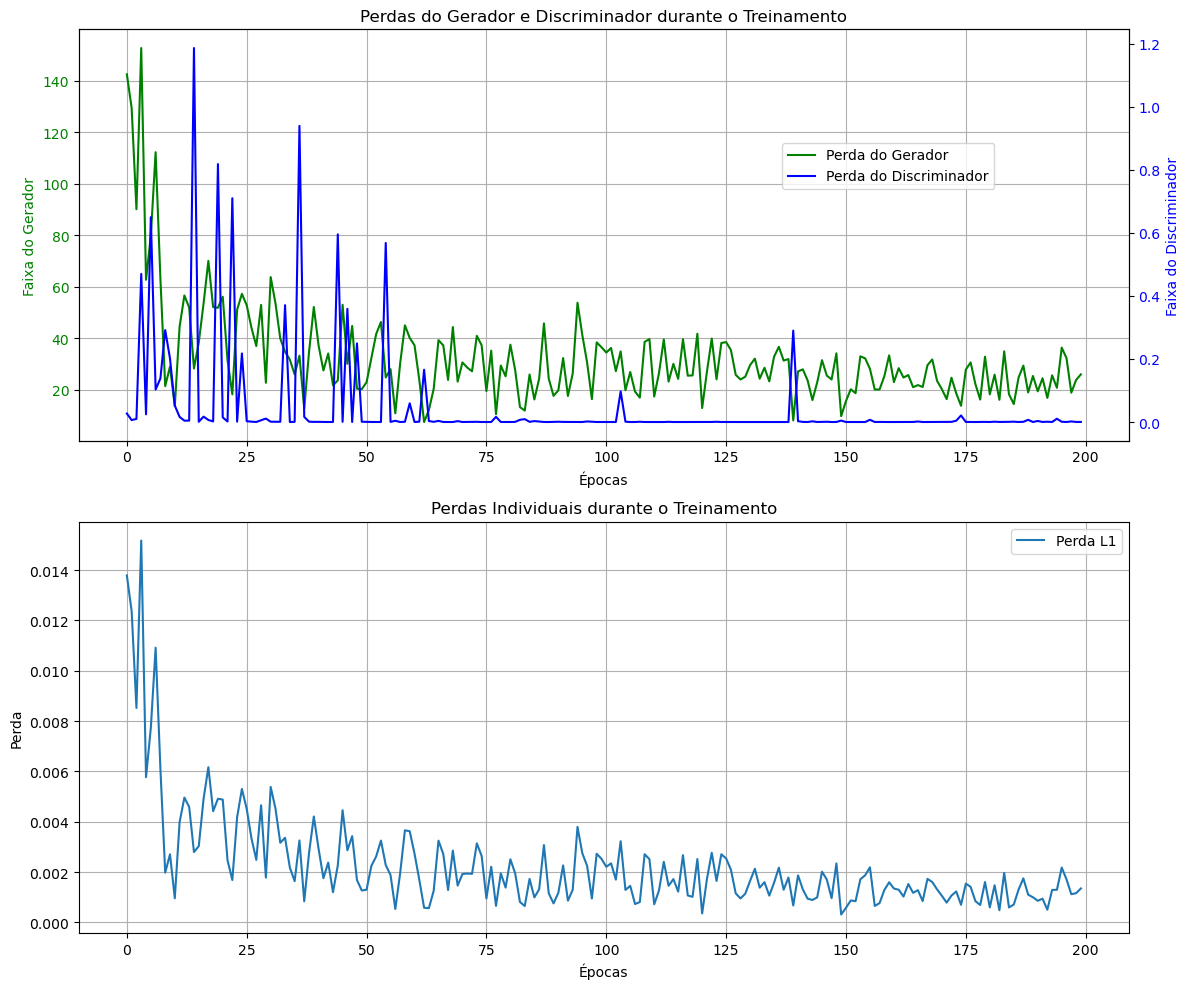

In [24]:
fig, (ax1, ax3) = plt.subplots(2,1, figsize=(12, 10))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VX_combined.png')
plt.show()

In [26]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VXcheckpoint.pth')

checkpoint = torch.load('pix2pix_P2VXcheckpoint.pth', weights_only=True)

G = GeneratorUnet(1) 
D = Discriminator(2) 

# Carregue o estado do gerador e discriminador
G.load_state_dict(checkpoint['generator_state_dict'])
D.load_state_dict(checkpoint['discriminator_state_dict'])

# Carregue os otimizadores
optimizer_G.load_state_dict(checkpoint['generator_optimizer_state_dict'])
optimizer_D.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

if cuda:
    G = G.cuda()
    D = D.cuda()

TypeError: Invalid shape (4, 1, 768, 361) for image data

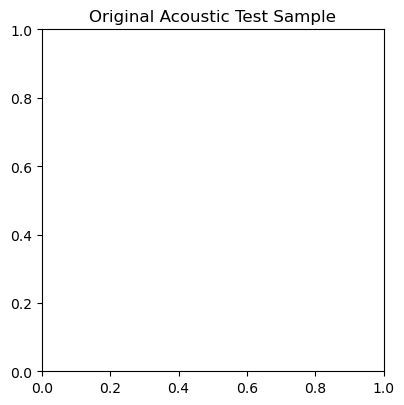

In [31]:
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    # Splitting 1024x768 matrices into 256x256 patches and storing their positions
    patches = []
    positions = []
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
                positions.append((i, j))  # Store positions as (row, col)
    return np.array(patches), positions

def reconstruct_from_patches(patches, positions, original_shape, patch_size=256):
    # Reconstruct the original image from patches using stored positions
    reconstructed = np.zeros(original_shape)

    for idx, (patch, (i, j)) in enumerate(zip(patches, positions)):
        # Se o patch ainda for um tensor PyTorch, desconecte-o do grafo computacional e converta para NumPy
        if isinstance(patch, torch.Tensor):
            patch = patch.detach().numpy()  # Detach and convert to NumPy array

        # Remova o canal extra (dimensão 1) se ele existir
        if patch.shape[-1] == 1:
            patch = np.squeeze(patch, axis=-1)
        
        # Coloque o patch de volta na posição original
        reconstructed[i:i+patch_size, j:j+patch_size] = patch

    return reconstructed


## Process the test data
for test_batch in test_dl:
    
    test_acustic, test_elastic = test_batch[0], test_batch[1]  # Assuming test_batch[0] is acoustic and test_batch[1] is elastic
    test_acustic = test_acustic.squeeze(0).squeeze(0)  # Remove batch dimension
    test_elastic = test_elastic.squeeze(0).squeeze(0)  # Remove batch dimension

    # Split acoustic test data into patches
    patches, positions = split_into_patches(test_acustic.numpy(), patch_size=256, vertical_overlap=0, horizontal_overlap=151)

    # Pass each acoustic patch through the generator G
    generated_patches = []
    for patch in patches:
        patch_tensor = torch.tensor(patch).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        patch_tensor = patch_tensor.to(device)  # Send to GPU if available
        generated_patch = G(patch_tensor)
        generated_patch = generated_patch.squeeze(0).squeeze(0).cpu()
        generated_patch = generated_patch.squeeze(0)
        generated_patches.append(generated_patch)

    # Reconstruct the image from the generated patches
    reconstructed_image = reconstruct_from_patches(generated_patches, positions, (768, 361), patch_size=256)

    break

# Definir o percentual
perc = 99
# Calcular os valores de vmax e vmin com base nos dados
vmax = np.percentile(np.abs(test_acustic), perc)
vmin = -vmax

# Visualize the original acoustic, elastic, and reconstructed image
plt.figure(figsize=(15, 8))

plt.subplot(1,3, 1)
plt.title("Original Acoustic Test Sample")
plt.imshow(test_acustic, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1,3, 2)
plt.title("Corresponding Elastic Test Sample")
plt.imshow(test_elastic, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1,3, 3)
plt.title("Reconstructed Image After Generator")
plt.imshow(reconstructed_image, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.savefig('Acoustic to Elastic (Pós-treino)')
plt.show()